In [1]:
#Importing the needed Python Libraries
import pandas as pd
import numpy as np
import json
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
from plotly.colors import n_colors

from IPython.core.display import display, HTML, Javascript 
import IPython.display
from IPython.display import display, clear_output

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
#load the responses of the survey
df = pd.read_csv("../input/kaggle-survey-2022/kaggle_survey_2022_responses.csv")

#get the questions' titles
questions_titles =  df[0:1]

#remove first row from DataFrame
df = df[1:]

In [3]:
#Helper Functions to create visualizations using Plotly

def create_scatter_plot(
    x_axis_values,
    y_axis_values, 
    hover_template,
    marker_color, 
    marker_size, 
    title,
    subtitle,
    subtitle_explain):
    """It creates a Scatter Plot."""
    
    # Define the trace
    trace = go.Scatter(
        x=x_axis_values, 
        y=y_axis_values,
        mode='markers', 
        hovertemplate=hover_template,
        marker=dict(
            color=marker_color,
            size=marker_size,
            showscale=True,
            colorbar=dict(title="Percent"),
            opacity=0.7,
            colorscale = 'GnBu'
        )
    )

    # Define the layout 
    layout = go.Layout(
        width=900, 
        height=950, 
        plot_bgcolor="#fff", 
        paper_bgcolor="#fff", 
        showlegend = False, 
        title = {
            'text' : f"<span style='font-size:30px; font-family:Times New Roman'>{title}</span><br><br><sup>{subtitle}</sup><br><sup>{subtitle_explain}</sup>", 
            'x':0.5,
            'xanchor': 'center'
        }, 
        font = {"color" : '#0E185F'},
        margin = dict(t=170),
    )
    
    fig = go.Figure(data = [trace], layout = layout)
    
    fig.update_xaxes(
        showline=False,
        linewidth=1,
        linecolor='#0E185F',
        gridcolor='#0E185F',
        tickfont=dict(size=14, family='Open Sans', color='#0E185F'), 
        title="",
        title_font=dict(size=14, family='Open Sans', color='#0E185F'),
        showgrid=False, 
        tickangle=325
    )
    fig.update_yaxes(
        showline=False,
        linewidth=1,
        linecolor='#000',
        gridcolor='#fff',
        tickfont=dict(size=14, family='Verdana', color='#0E185F'), 
        title="",
        title_font=dict(size=14, family='Verdana', color='#0E185F'),
        showgrid=False
    )

    fig.show()


def get_bar_plot_trace(x_values, y_values, display_text, top_n, rest_n, hovertext, orientation="h"):
    """It creates the trace for a bar plot."""
    
    trace = go.Bar(
        y = y_values,
        x = x_values,
        name = "",
        orientation = orientation,
        marker = dict(color = ["#34C3CA"]*rest_n +  ["#0282C8"]*top_n),
        text = display_text,
        texttemplate =  "<b style='color: #fff'>%{text}% </b>",
        textposition = ["outside"]*rest_n + ["inside"]*top_n,
        hovertext=hovertext
    )
    
    return trace


def create_single_bar_plot(x_values, y_values, display_text, top_n, rest_n, hovertext, title, subtitle="", orientation="h"):
    """It creates single bar plots."""

    trace = get_bar_plot_trace(x_values, y_values, display_text, top_n, rest_n, hovertext, orientation)

    large_title_format = f"<span style='font-size:30px; font-family:Times New Roman'>{title}</span>"
    
    layout = dict(
        title = large_title_format,
        font = dict(color = '#0E185F'),
        margin = dict(t=120),
        yaxis={'categoryorder':'array','categoryarray': x_values},
        xaxis=dict(side="top", zerolinecolor = "#4d4d4d", zerolinewidth = 0.5, gridcolor="#e7e7e7", tickformat=",.1%"),
        width = 800,
        height= 700,
        plot_bgcolor = "white"
    )

    fig = go.Figure(data = trace, layout = layout)
    fig.show()
    
    
def create_box_plot(df, x_column_name, y_column_name, title):
    """It creates bar plots."""

    fig = px.box(
        df, 
        x=x_column_name, 
        y=y_column_name,
        title=f"<span style='font-size:30px; color:#115f9a; font-family:Times New Roman'>{title}</span>")

    layout = go.Layout(
        xaxis= {"title": ""},
        yaxis= {"title": "Compensation in USD"},
        font = dict(color = 'black'),
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        height=800,
        width=1050
    )

    fig.update_layout(layout)
    fig.update_yaxes(showline=True, linewidth=1, gridcolor='lightgrey')
    fig.update_traces(marker_color='#22a7f0')

    fig.show() 

def create_heatmap(z, x, y, annotation_text, color_scale, title, subtitle="", xlabel="", ylabel=""):
    """It creates a heatmap."""

    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=annotation_text,  colorscale=color_scale)

    large_title_format = f"<span style='font-size:30px; font-family:Times New Roman'>{title}</span>"
    small_title_format = f"<span style='font-size:14px; font-family:Helvetica'>{subtitle}</b></span>"


    layout = dict(
        title = large_title_format + "<br>" + small_title_format,
        font = dict(color = '#0E185F'),
         xaxis= {"title": xlabel},
        yaxis= {"title": ylabel},

    )

    fig['layout'].update(layout)
    fig["layout"]["xaxis"].update(side="bottom")
    fig.show()

In [4]:
#this section has all the python functions and global variables needed for the analysis
#Categorizing the state of Machine Learning Adoption into more general categories
map_ml_adoption = {
    "No (we do not use ML methods)": "Not Started" , 
    "We are exploring ML methods (and may one day put a model into production)": "Exploration Stage",
    "We use ML methods for generating insights (but do not put working models into production)": "Generating Insights", 
    "We recently started using ML methods (i.e., models in production for less than 2 years)": "Models in Production",
    "We have well established ML methods (i.e., models in production for more than 2 years)": "Models in Production",
    "I do not know": "Not Known",
    np.nan: "Not Known"
}


# Colors for different Machine Learning Adoption Stages
ml_adoption_color_discrete_map={
    "Models in Production":"#4B6370", 
    "Generating Insights": "#34C3CA", 
    "Exploration Stage":"#89CFFD",
    "Not Started": "#0282C8",
    "Not Known": "#3F9DD0"
}


# Rephrasing the ML Adoption (state) by adding numbers for sorting them alphabetically
map_ml_usage = {
    "No (we do not use ML methods)": "0. Not Started<br><sup>(No ML)</sup>" , 
    "We are exploring ML methods (and may one day put a model into production)": "1. Exploration<br><sup>Only Exploring ML</sup>",
    "We use ML methods for generating insights (but do not put working models into production)": "2. Beginner Stage<br><sup>Use ML only for Insights</sup>", 
    "We recently started using ML methods (i.e., models in production for less than 2 years)": "3. Intermediate Stage<br><sup>Recently Started Using ML</sup>",
    "We have well established ML methods (i.e., models in production for more than 2 years)": "4. Advance Stage<br><sup>Well Established ML</sup>",
    "I do not know": "Not Known",
    np.nan: "Not Known"   
}


#Rephrasing the Company Size by adding numbers for sorting them alphabetically
map_company_size = {
    "0-49 employees": "1. 0-49 employees" , 
    "50-249 employees": "2. 50-249 employees",
    "250-999 employees": "3. 250-999 employees",
    "1000-9,999 employees": "4. 1000-9,999 employees",
    "10,000 or more employees": "5. 10,000 or more employees",
    np.nan: np.nan   
}


#Rephrasing the Coding experience by adding numbers for sorting them alphabetically
map_programming_experience = {
    "I have never written code": "1. 0 years",
    "< 1 years": "2. < 1 years",
    "1-3 years": "3. 1-3 years",
    "3-5 years": "4. 3-5 years",
    "5-10 years": "5. 5-10 years",
    "10-20 years": "6. 10-20 years",
    "20+ years": "7. 20+ years",
    np.nan: np.nan
}


#Rephrasing the Machine Learning experience by adding numbers for sorting them alphabetically
map_ml_experience = {
    "I do not use machine learning methods": "1. 0 years",
    "Under 1 year": "2. < 1 years",
    "1-2 years": "3. 1-2 years",
    "2-3 years": "4. 2-3 years",
    "3-4 years": "5. 3-4 years",
    "4-5 years": "6. 4-5 years",
    "5-10 years": "7. 5-10 years",
    "10-20 years": "8. 10-20 years",
    "20+ years": "9. 20+ years",
    np.nan: np.nan
}


#Rephrasing the Data Science Teams Size by adding numbers for sorting them alphabetically
map_data_team_size = {
    "0": "1. 0",
    "1-2": "2. 1-2",
    "3-4": "3. 3-4",
    "5-9": "4. 5-9",
    "10-14": "5. 10-14",
    "15-19": "6. 15-19",
    "20+": "7. 20+",
    np.nan: np.nan
}


#Get a plotly Dataset with all the countries along with the continent in which they belong
countries_df = px.data.gapminder().query("year == 2007")
countries_df["country"] = countries_df["country"].str.strip()

map_country_continent = {
    "United States of America": "Americas", 
    "United Kingdom of Great Britain and Northern Ireland": "Europe",
    "South Korea": "Asia", 
    "Russia": "Europe",
    "Viet Nam": "Asia",
    "Hong Kong (S.A.R.)": "Asia",
    "Ukraine": "Europe",
    "United Arab Emirates": "Asia",
    "Iran, Islamic Republic of...": "Asia",
    
}


def fix_map_country_continent(map_countries: dict, country:str, continent:str):
    """It maps a country to its continent"""
    if country in map_countries:
        return map_countries[country]
    
    return continent


def usage_of_a_product_or_service(question_title: str, row: pd.Series, columns_list: list) -> str:
    """It takes as input a question title with multiple choices answers and checks if the respondent 
    has selected at least one of the answers or not. 
    """
    for col in columns_list:
        if col.startswith(question_title):

            if not pd.isnull(row[col]) and row[col].strip().lower() != "none":
                return "Yes"
    return "No"


def categorize_education(education:str) -> str:
    """Assigns more general categories to education levels."""
    if education in [
        "No formal education past high school", 
        "Some college/university study without earning a bachelor’s degree"
    ]:
        return "Lower than Bachelor"
    
    if education == "Bachelor’s degree":
        return "Bachelor"
    
    if education == "Master’s degree":
        return "Master"
    
    if education in ["Doctoral degree", "Professional doctorate"]:
        return "Higher than Master"
    
    return "Other"


def extract_and_count_all_the_multiple_choice_answers(question, df):
    """If we have a question with multiple choices it returns a data
    frame with the number of occurrences of each choice in the responses. 
    """
    
    choices_list = [choice for choice in df.columns if choice.startswith(question)]
    dfs_list = []
    for col in choices_list:
        dfs_list.append(df.groupby([col]).agg({"Q2" : "count"}).reset_index().rename(columns={col: question, "Q2": "counts"}))

    agg_df = pd.concat(dfs_list)
    agg_df["relative_percent"] = agg_df.apply(lambda x : (x["counts"] / df.shape[0]), axis = 1)
    agg_df = agg_df.sort_values(by=["relative_percent"], ascending=True)
    
    return agg_df


def assign_label(service:str):
    """It returns the company name to which the product belongs. 
    It takes care only of the 3 big techs: Google, Amazon, Microsoft, IBM.
    """
    
    if "google" in service.lower():
        return "Google"
    
    if "aws" in service.lower() or "amazon" in service.lower():
        return "Amazon"
    
    if "azure" in service.lower() or "microsoft" in service.lower():
        return "Microsoft"
    
    if "ibm" in service.lower():
        return "IBM"

    return "Other"


def extract_the_number_of_responses(question_title: str, row: pd.Series, columns_list: list) -> str:
    """It takes as input an answer from a multiple-choice question and counts the number 
    of respondents that have chosen it.
    """
    num_responses = 0 
    for col in columns_list:
        if col.startswith(question_title):
            if not pd.isnull(row[col]):
                num_responses = num_responses + 1 

    return num_responses


def wrap_df_text(df):
    return display(HTML(df.style.background_gradient(axis=0,  cmap='YlOrBr', subset=["Average number of selected choices"]).to_html().replace("\\n","<br>")))


In [5]:
#respondents that currently are not students (answered **No** to the **Q5** question)
#are currently employed (they didn't answer the **Q23** question that "Currently not employed")
#have answered in what industry they are currently employed (or their most recent employer if retired) - **Q24 question has an answer**

scope_df = df[
    (df["Q5"] == "No") & 
    (df["Q24"].notnull()) &
    (df["Q23"] != "Currently not employed")
]


#Assign more general categories to the state of Machine Learning Adoption in industry
scope_df["ML_adoption_class"] = scope_df["Q27"].apply(lambda x : map_ml_adoption[x])

#Rephrasing the ML Adoption (state) by adding numbers for sorting them alphabetically
scope_df["ML_adoption"] = scope_df["Q27"].apply(lambda x : map_ml_usage[x])

#Rephrasing the size of the company by adding numbers for sorting them alphabetically
scope_df["Q25"] = scope_df["Q25"].apply(lambda x : map_company_size[x])

#Check if the respondent used Cloud Computing Platforms
scope_df["Cloud_usage"] = scope_df.apply(lambda row: usage_of_a_product_or_service("Q31", row, list(scope_df.columns)), axis=1)
scope_df["NLP_methods_usage"] = scope_df.apply(lambda row: usage_of_a_product_or_service("Q20", row, list(scope_df.columns)), axis=1)
scope_df["CV_methods_usage"] = scope_df.apply(lambda row: usage_of_a_product_or_service("Q19", row, list(scope_df.columns)), axis=1)
scope_df["GPU_usage"] = scope_df.apply(lambda row: usage_of_a_product_or_service("Q42", row, list(scope_df.columns)), axis=1)


scope_df["Q11"] = scope_df["Q11"].apply(lambda x : map_programming_experience[x])
scope_df["Q16"] = scope_df["Q16"].apply(lambda x : map_ml_experience[x])
scope_df["Q26"] = scope_df["Q26"].apply(lambda x : map_data_team_size[x])

industry_totals = scope_df["Q24"].value_counts().to_dict()

## <span style="color: #115f9a;">Adoption of Data Science and Machine Learning in Industry</span>

It is obvious that adoption of Data Science and Machine Learning can transform older, traditional banks into more digitally savvy banks capable of competing with the rise of more digitally-driven ones of the modern age. AI adoption can benefit other industries as well. The findings from the latest [McKinsey Global Survey](https://www.mckinsey.com/capabilities/quantumblack/our-insights/global-survey-the-state-of-ai-in-2021) about the state of AI in 2021 indicate that AI adoption continues to grow and that the benefits remain significant. A majority of McKinsey survey respondents now say their organizations have adopted AI capabilities, as AI’s impact on the bottom line is growing.

However, operationalizing and scaling machine learning to drive business value can be challenging. My experience has shown that, while many businesses have started diving into it, only a few data science projects actually make it to production. Moving from the experiment phase of ML to real-world deployment is difficult, as the journey requires finetuning ML models to fit the practical needs of a business and ensuring the solution can be implemented at scale.

**ML Operationalization:**

<img width="790" alt="image" style="display: block; margin: 0 auto" src="https://user-images.githubusercontent.com/28102493/198541622-0a50ee53-3e53-4d7d-acef-5106d6ccbe70.png">
<div style="text-align: center;">Source Nvidia Blog: <a href="https://blogs.nvidia.com/blog/2020/09/03/what-is-mlops/ ">What Is MLOps?</a></div>

Models as part of an experiment are good, but models in production are great. MLOps, as the name implies, brings operationalization to the table, providing resources for bringing models from test environments into production. 

## <span style="color: #115f9a;">Analysis's Target</span>

The goal of this notebook is to extract insights from the responses of [2022 Kaggle Machine Learning & Data Science Survey](https://www.kaggle.com/competitions/kaggle-survey-2022) 
about the state of AI Adoption and ML Operationalization in the industry in 2022 as well as about the Data Science landscape in the market. As I'm curious to see how the MLOps and AI adoption progressing in other organizations and what's the current trends in Data Science I'll try to enlighten the following main topics:

1. **What's the state of Machine Learning adoption in the enterprise today?** 
    - What's the percentage of enterprises deploying data science and machine learning in production today? 
    - Does the company's size or sector play a role in AI Adoption? Are larger companies more likely than smaller companies to have deployed AI in their organization?

1. **What's the enterprise AI tech stack?** The modern AI stack is a collection of tools, services, and processes imbibed with MLOps practices that allow developers and operations teams to build ML pipelines efficiently in terms of resource utilization, team efforts, end-user experience, and maintenance activities. It would be interesting if, for instance, we would answer the following questions:
    - Are Cloud-native solutions a must-have for business today?
    - What are the most popular tools for Data Storage, Data Management, AutoML, Business Intelligence, etc.?
    - What frameworks and libraries are commonly used in the market for Machine Learning and Data Science?
    - Are transfer learning methods mature enough to be used in the business environment?
    - Do we really work with big data and deep learning methods to such an extent that we need specialized hardware for ML models training?

1. **AI Careers & Job Outlook in 2022:**
    - What are the top AI job positions?
    - What does an AI professional do?
    - What are the professional AI skills in demand for 2022?

1. **AI Salary Overview**


## <span style="color: #115f9a;">Methodology</span>

In order to have as much as I can a representative dataset for the analysis, I'll keep in the dataset only the respondents that fulfill the following criteria :

- currently are not students (answer **No** to the question **Q5**)
- currently are employed (They didn't answer "Currently not employed" to the **Q23** question)
- have answered in what industry they are currently employed (or their most recent employer if retired) - **Q24 question has an answer, not None**

As it can be seen below, ~ **37.9% of the total responses** meet the above criteria and the analysis will be conducted based on these responses.

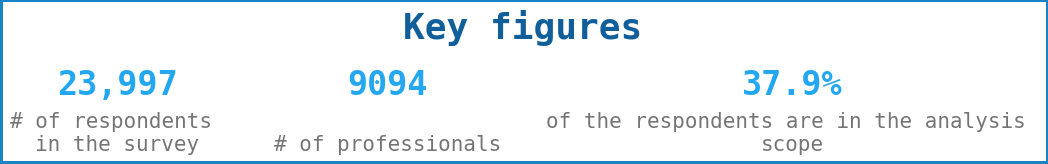

In [6]:
mpl.rcParams.update(mpl.rcParamsDefault)

fig1 = plt.figure(figsize=(5,2),facecolor='white')

ax1 = fig1.add_subplot(1,1,1)
font = 'monospace'
ax1.text(0.9, 0.8, "Key figures",color='#115f9a',fontsize=26, fontweight='bold', fontfamily=font, ha='center')


ax1.text(0, 0.4, "{:,d}".format(df.shape[0]), color='#22a7f0', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax1.text(0, 0.001, "# of respondents \nin the survey",color='#757575',fontsize=15, fontweight='light', fontfamily=font,ha='center')

ax1.text(0.6, 0.4, "{}".format(scope_df.shape[0]), color='#22a7f0', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax1.text(0.6, 0.001, "# of professionals",color='#757575',fontsize=15, fontweight='light', fontfamily=font,ha='center')


ax1.text(1.5, 0.4, "{}".format(round((scope_df.shape[0]/df.shape[0] )*100, 2))+"%", color='#22a7f0', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax1.text(1.5, 0.001, "of the respondents are in the analysis \nscope",color='#757575',fontsize=15, fontweight='light', fontfamily=font, ha='center')

ax1.set_yticklabels('')
ax1.tick_params(axis='y',length=0)
ax1.tick_params(axis='x',length=0)
ax1.set_xticklabels('')

for direction in ['top','right','left','bottom']:
    ax1.spines[direction].set_visible(False)

fig1.subplots_adjust(top=0.9, bottom=0.2, left=0, hspace=1)

fig1.patch.set_linewidth(3)
fig1.patch.set_edgecolor('#1984c5')
fig1.patch.set_facecolor('white')
ax1.set_facecolor('white')
    
plt.show()

## <span style="color: #115f9a;">Outlier Analysis</span>

It would be also interesting to examine if there are some **"outlier respondents"** that have marked all the answers for the multiple-choice questions. 

For that, I calculated the average number of choices that each respondent selected in the multiple-choice questions. I found out that each respondent selects 1 - 2 options in the multiple-choice questions on average. 


Only 2% of the respondents in the scope have an average number of selections greater than 3, which cannot affect the results of the analysis. **Also, it doesn't necessarily mean that we have to address them as outliers. One explanation would be that they might have many years of coding or ML experience, so makes sense to be familiar with many frameworks and work with a variety of libraries.** 

As the tables below illustrate, this hypothesis is valid since the biggest percentage of the respondents with more than 3 selections on average, have strong coding and machine learning experience. 

So I won't discard these respondents or treat them differently. 

In [7]:
#Collecting all the multiple-choice questions
multiple_choice_questions = {}
seen_columns = []

for col in df.columns:
    question = col.split("_")[0]
    if question in seen_columns:
        if question not in multiple_choice_questions:
            multiple_choice_questions[question] = 2
        else: 
            multiple_choice_questions[question] = multiple_choice_questions[question] + 1
    else:
        seen_columns.append(question)

# Create a new column in the dataframe for each of the multiple-choice questions which
# shows the number of the choices that the respondent selected for each one respectively.
for col in list(multiple_choice_questions.keys()):
    scope_df[f"{col}_number_of_responses"] = scope_df.apply(
        lambda x : extract_the_number_of_responses(col,x, df.columns), axis = 1)
    

In [8]:
respondents_mean_responses = scope_df[[f"{col}_number_of_responses" for col in list(multiple_choice_questions.keys())]].mean(axis = 1).reset_index().rename(columns={0: "Mean number of responses"})
outliers = scope_df.filter(items=respondents_mean_responses[respondents_mean_responses["Mean number of responses"] > 3]["index"].to_list(), axis=0)
outliers = outliers.groupby(
    ["Q16"]
).agg(
    {"Q2" : "count"}
).reset_index().rename(
    columns={"Q2": "Nbr of respondents", "Q16": "Years of Machine Learning Experience"}
).sort_values(by=["Years of Machine Learning Experience"])
outliers["%"] = outliers.apply(lambda x : x["Nbr of respondents"] / outliers["Nbr of respondents"].sum(), axis = 1)
outliers["%"] = np.round(outliers["%"]* 100, 2)
outliers.style.background_gradient(axis=0,  cmap='GnBu', subset=["%"])

,Years of Machine Learning Experience,Nbr of respondents,%
0,2. < 1 years,12,6.320000
1,3. 1-2 years,30,15.790000
2,4. 2-3 years,34,17.890000
3,5. 3-4 years,24,12.630000
4,6. 4-5 years,27,14.210000
5,7. 5-10 years,49,25.790000
6,8. 10-20 years,14,7.370000


In [9]:
outliers = scope_df.filter(items=respondents_mean_responses[respondents_mean_responses["Mean number of responses"] > 3]["index"].to_list(), axis=0)
outliers = outliers.groupby(
    ["Q11"]
).agg(
    {"Q2" : "count"}
).reset_index().rename(
    columns={"Q2": "Nbr of respondents", "Q11": "Years of Coding Experience"}
).sort_values(by=["Years of Coding Experience"])
outliers["%"] = outliers.apply(lambda x : x["Nbr of respondents"] / outliers["Nbr of respondents"].sum(), axis = 1)
outliers["%"] = np.round(outliers["%"]* 100, 2)
outliers.style.background_gradient(axis=0,  cmap='GnBu', subset=["%"])

,Years of Coding Experience,Nbr of respondents,%
0,2. < 1 years,10,5.260000
1,3. 1-3 years,32,16.840000
2,4. 3-5 years,28,14.740000
3,5. 5-10 years,50,26.320000
4,6. 10-20 years,41,21.580000
5,7. 20+ years,29,15.260000


In the table below, we can also see the average number of choices that respondents selected for each of the multiple-choice questions and we might be able to conclude the following findings:

- The professionals who participated in the survey, use on average 2 programming languages on a regular basis, 3 Machine Learning Algorithms and 2 Machine Learning Frameworks.
- In addition, they usually don't use natural language processing (NLP) methods like Word embeddings/vectors, Encoder-decoder models, Contextualized embeddings, or Transformer language models

In [10]:
outlier_analysis = []

for col in list(multiple_choice_questions.keys()):
    mean_responses = round(scope_df[f"{col}_number_of_responses"].mean())
    outlier_analysis.append([
        col,
        multiple_choice_questions[col], 
        mean_responses,
    ])
    
average_responses = pd.DataFrame(outlier_analysis, columns = ["Question", "Nbr of available Choices", "Average number of selected choices"])
average_responses["Question Title"] = questions_titles[[f"{col}_1" for col in list(multiple_choice_questions.keys())]].loc[0].to_list()
average_responses["Question Title"] = average_responses["Question Title"].apply(lambda x : x.split("(Select")[0].strip())

#Updates the DataFrame in place
scope_df.drop([f"{col}_number_of_responses" for col in list(multiple_choice_questions.keys())], axis = 1, inplace=True)

average_responses["Question Title"] = average_responses['Question Title'].str.wrap(80)
average_responses = average_responses[["Question", "Question Title", "Nbr of available Choices", "Average number of selected choices"]]

wrap_df_text(average_responses)



,Question,Question Title,Nbr of available Choices,Average number of selected choices
0,Q6,On which platforms have you begun or completed data science courses?,12,2
1,Q7,What products or platforms did you find to be most helpful when you first started studying data science?,7,2
2,Q10,"Did your research make use of machine learning? - Yes, the research made advances related to some novel machine learning method (theoretical research)",3,0
3,Q12,What programming languages do you use on a regular basis?,15,2
4,Q13,Which of the following integrated development environments (IDE's) do you use on a regular basis?,14,3
5,Q14,Do you use any of the following hosted notebook products?,16,1
6,Q15,Do you use any of the following data visualization libraries on a regular basis?,15,2
7,Q17,Which of the following machine learning frameworks do you use on a regular basis?,15,2
8,Q18,Which of the following ML algorithms do you use on a regular basis?,14,3
9,Q19,Which categories of computer vision methods do you use on a regular basis?,8,1


## <span style="color: #115f9a;">Table of Contents</span>

- [What's the state of Machine Learning adoption in the enterprise today?](#ml-adoption-state)
- [Overview of the enterprise AI technology stack](#ai-tech-stack)
    - [Usage of Cloud Computing Platforms ](#cloud-usage)
    - [Which cloud computing platforms are used for Machine Learning operations?](#cloud-computing-platforms)
    - [Machine Learning tools & products popular in 2022](#ml-tools)
    - [Frameworks, libraries and languages for Machine Learning & Data Science](#ml-libraries)
    - [Transfer learning in the business world](#transfer-learning)
    - [Usage of specialized hardware for ML models training](#gpu-usage)
- [AI job roles and key skills needed to build a career in AI](#jobs)
    - [AI jobs description: roles, responsibilities and skills required](#jobs-roles)
    - [Data science team sizing](#ds-size)
    - [What education do AI specialists need?](#education)
- [Artificial Intelligence salaries (by role, industry, education & more)](#salary)
- [Conclusion](#conclusion)
- [References](#references)
  

<a id="ml-adoption-state"></a>

# <div style="padding:20px;color:white;margin:0;font-size:24px;text-align:left;display:fill;border-radius:5px;background-color:#115f9a;overflow:hidden">What's the state of Machine Learning adoption in the enterprise today?</div>

The first thing that I want to understand from the survey responses, is the state of ML adoption in different industries today. In the 2022 Kaggle Machine Learning & Data Science survey of 9,094 professionals coming from different industries, as it can be seen in the chart below,

- a percentage of 25.52% working in tech companies,
- a 15.91% in the academic field, 
- and the rest distributed from the finance sector to shipping and transportation. 

**Which sector would you bet is a high performer in AI and has made big progress in terms of AI adoption?** 

First, let's see how AI adoption looks like broadly, across all sectors, in 2022. 

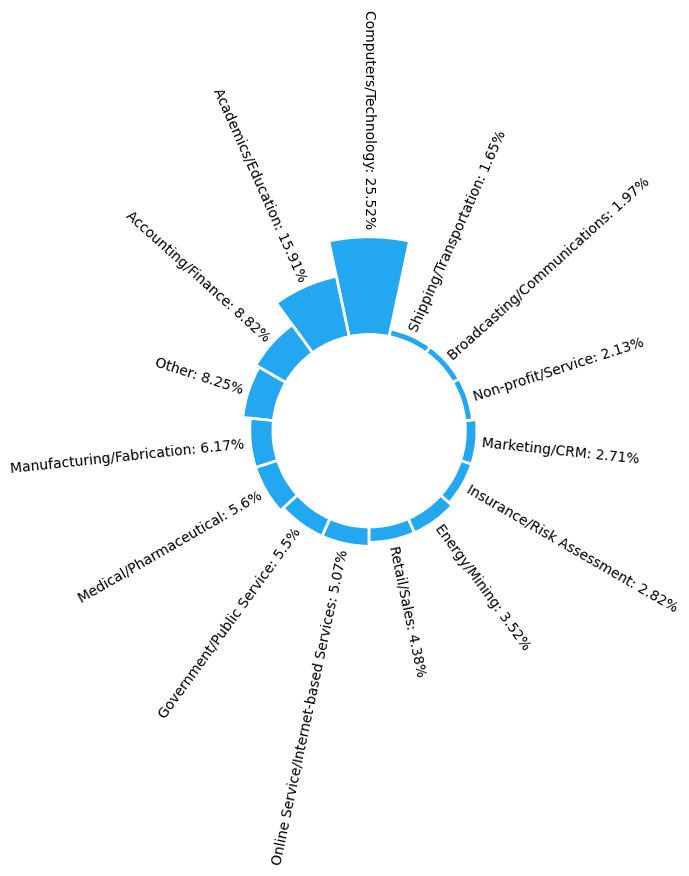

In [11]:
def get_label_rotation(angle, offset):
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment


def add_labels(angles, values, labels, offset, ax):
    padding = 6
    for angle, value, label, in zip(angles, values, labels):
        angle = angle
        
        rotation, alignment = get_label_rotation(angle, offset)
        y = value + padding
        
        ax.text(
            x=angle, 
            y=y, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor",
        ) 


ANGLES = np.linspace(0, 2 * np.pi, scope_df["Q24"].nunique(), endpoint=False)
VALUES = np.round(scope_df["Q24"].value_counts(normalize=True).values, 2)*400
LABELS = scope_df["Q24"].value_counts().index


#width of each bar 
#the circumference is '2 * pi', so we divide that total width over the number of bars.
WIDTH = 2 * np.pi / len(VALUES)

#where to place the first bar. 
#By default, matplotlib starts at 0 (the first bar is horizontal)
#but here we start at pi/2 (90 deg)
OFFSET = np.pi / 2

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": "polar"})

# Specify offset
ax.set_theta_offset(OFFSET)

# Set limits for radial (y) axis. The negative lower bound creates the whole in the middle.
ax.set_ylim(-100, 100)

# Remove all spines
ax.set_frame_on(False)

# Remove grid and tick marks
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Add bars
ax.bar(
    ANGLES, VALUES, width=WIDTH, linewidth=2,
    color="#22a7f0", edgecolor="white"
)

final_labels = []
test = list(np.round(scope_df["Q24"].value_counts(normalize=True).values*100,2))
count = 0 
for label in LABELS:
    final_labels.append(f"{label}: {test[count]}%")
    count = count+ 1
np.array(final_labels)

# Add labels
add_labels(ANGLES, VALUES, final_labels, OFFSET, ax)
plt.show()

The data shows that about **33%** of respondents say that their organizations have Machine Learning models in production, either in an advanced stage or in an intermediate stage (they recently started using ML methods), while a percentage of **10.2%** uses ML methods for generating insights. However, a considerable percentage of the participants, **21.7%**, answered that their companies haven't started yet using AI and ML techniques while **17.1%** of the respondents say that have started exploring the capabilities of this new technology. 

In [12]:
ml_adoption = scope_df.groupby(
    ["ML_adoption_class", "ML_adoption"]
).agg(
    {"Q2" : "count"}
).reset_index().rename(
    columns={"Q2": "counts"}
)

##first Plot
fig = go.Figure(data=[go.Pie(
    labels=scope_df["ML_adoption_class"].value_counts().index.to_list(), 
    values=list(scope_df["ML_adoption_class"].value_counts().values),
    hole=.4
)])

fig.update_traces(marker=dict(colors=['#4B6370','#34C3CA','#89CFFD','#0282C8','#3F9DD0']))

large_title_format = "<span style='font-size:30px; font-family:Open-sans'>The State of the ML Adoption in Inudstry in 2022</span>"
small_title_format = "<span style='font-size:14px; font-family:Helvetica'></b></span>"

layout = dict(
    title = large_title_format + "<br>" + small_title_format,
    font = dict(color = '#0E185F'),
    showlegend = True,
    margin = dict(t=80,pad=0),

)
fig["layout"].update(layout)

fig.show()

## Second Plot
fig = px.sunburst(
    ml_adoption, 
    path=["ML_adoption_class", "ML_adoption"], 
    values="counts", 
    color="ML_adoption_class",
    color_discrete_map=ml_adoption_color_discrete_map
)

layout = dict(
    showlegend = False,
    margin = dict(t=80,pad=0, l=0),

)
fig["layout"].update(layout)

fig.show()

It is clear in the following chart that companies providing **Internet-based services** have a **better adoption of Machine Learning and Data Science** followed by **Insurance companies**, whereas **non-profit organizations and the government sector score undoubtedly lower for the adoption of various AI-related technologies.** A key reason for the lower AI adoption among governments and non-profit organizations is the bureaucracy and the established processes that take too long. In these sectors, might be less encouragement for employees to take risks and innovate. 

In the private sector, employers tend to put a strong focus on experimentation, innovation, and growth. For instance, **companies providing Internet-based services** could gather many data from the user's online activities and the employees can apply analytics and other innovative ideas in order to improve the services that their company provides. The **insurance sector** is also leveraging AI technologies for insurance advice, underwriting claims processing, fraud prevention, risk management, and direct marketing. Customer behavior and advances in technology have opened the door for AI in the insurance market to create value, reduce costs, increase efficiency and achieve higher customer satisfaction and trust. **Retail** has also embraced AI technologies, with 27% of the professionals working in the retail sector, saying their companies have well-established machine learning methods in production.

In [13]:
#Get the counts of occurrences of each industry
ai_adoption_totals = scope_df["Q24"].value_counts().to_dict()

#Get the counts of occurrences of each ML adoption stage per industry
ai_adoption = scope_df.groupby(["Q24", "ML_adoption"]).agg({"Q2" : "count"}).reset_index().rename(columns={"Q2": "counts"})

#Get the relative percent 
ai_adoption["relative_percent"] = ai_adoption.apply(lambda x : x["counts"] / ai_adoption_totals[x["Q24"]], axis = 1)

#Ignore categories and states like not known, other, etc. 
ai_adoption = ai_adoption[ai_adoption["ML_adoption"]!= "Not Known"]

hover_template = "Industry: %{x}<br>" + "AI Adoption Stage: %{y}<br>" + "Percentage: %{marker.size:,}" + "<extra></extra>"

create_scatter_plot(
    ai_adoption["Q24"],
    ai_adoption["ML_adoption"].apply(lambda x : x.split(".")[-1]), 
    hover_template,
    ai_adoption['relative_percent']*100, 
    ai_adoption['relative_percent']*100, 
    "The State of Machine Learning Adoption by Industry",
    "Questions Data: Industry (Q24) and ML Adoption State (Q27)",
    "Size,Color: Percentage of Respondents - <br>The number of respondents of the related sector that chose the relevant adoption stage of their company <br>divided by the total number of respondents working in that sector."
)

In [14]:
adoption_per_company_size = scope_df.groupby(
    ["Q25", "ML_adoption_class"]
).agg({
    "Q2" : "count"
}).reset_index().rename(columns={
    "Q2": "counts"
})
adoption_per_company_size

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=adoption_per_company_size[adoption_per_company_size["ML_adoption_class"] == "Models in Production"].sort_values(by=["Q25"])["counts"].to_list(),
      theta=adoption_per_company_size[adoption_per_company_size["ML_adoption_class"] == "Models in Production"].sort_values(by=["Q25"])["Q25"].to_list(),
      fill='toself',
      name='Models in Production'
))
fig.add_trace(go.Scatterpolar(
      r=adoption_per_company_size[adoption_per_company_size["ML_adoption_class"] == "Exploration Stage"].sort_values(by=["Q25"])["counts"].to_list(),
      theta=adoption_per_company_size[adoption_per_company_size["ML_adoption_class"] == "Exploration Stage"].sort_values(by=["Q25"])["Q25"].to_list(),
      fill='toself',
      name='Exploration Stage'
))

fig.add_trace(go.Scatterpolar(
      r=adoption_per_company_size[adoption_per_company_size["ML_adoption_class"] == "Generating Insights"].sort_values(by=["Q25"])["counts"].to_list(),
      theta=adoption_per_company_size[adoption_per_company_size["ML_adoption_class"] == "Generating Insights"].sort_values(by=["Q25"])["Q25"].to_list(),
      fill='toself',
      name='Generating Insights'
))
fig.add_trace(go.Scatterpolar(
      r=adoption_per_company_size[adoption_per_company_size["ML_adoption_class"] == "Not Started"].sort_values(by=["Q25"])["counts"].to_list(),
      theta=adoption_per_company_size[adoption_per_company_size["ML_adoption_class"] == "Not Started"].sort_values(by=["Q25"])["Q25"].to_list(),
      fill='toself',
      name='Not Started'
))

large_title_format = "<span style='font-size:30px; font-family:Times New Roman'>Productionization of ML models by Company's size</span>"
small_title_format = "<span style='font-size:14px; font-family:Helvetica'></b></span>"


layout = dict(
    title = large_title_format + "<br>" + small_title_format,
    font = dict(color = '#0E185F'),
    showlegend = True,
    margin = dict(t=80,pad=6),

)
fig["layout"].update(layout)

fig.show()

**Another important insight that comes up from the analysis is that big companies are leading the way in AI adoption.**

The survey results show that larger companies, with 1000-9,999 employees or more than 10,000 are the leading AI adopters. There are several reasons that may explain why larger companies outpace smaller ones in AI adoption : large firms tend to serve large markets, they can better amortize the high fixed costs associated with employing AI production technologies over more sales, plus, they offer higher wages and more benefits, increasing the pool of top AI talent these firms have access to and also, because vendors of AI systems benefit from supplying companies with the largest consumer base, vendors may focus on creating relationships and contracts with larger firms, enabling these firms to be more exposed to the value AI systems can bring to their businesses.


<a id="ai-tech-stack"></a>

# <div style="padding:20px;color:white;margin:0;font-size:24px;text-align:left;display:fill;border-radius:5px;background-color:#115f9a;overflow:hidden">Overview of the enterprise AI technology stack</div>

Machine learning was mainly in the experimental stage in the enterprise market not long ago. The Data Science teams always start with a Proof Of Concept (POC) approach and eventually gain traction even with a non-standardized production deployment process because of the business results achieved by the model.  In order to scale this solution successfully with re-usability and reliability, the AI stack requires hardware and software optimizations in architectural areas of computing, memory, and networking. 

<a id="cloud-usage"></a>

## <span style="color: #115f9a;">Usage of Cloud Computing Platforms</span>

According to several reports about the [Cloud Computing Market in 2022](https://www.businesswire.com/news/home/20220831005645/en/Global-Cloud-Computing-Market-Report-2022-Increased-Resource-User-Mobility-and-Ongoing-Migration-of-Applications-Over-the-Cloud-Driving-Growth---ResearchAndMarkets.com), the adoption of cloud technologies continues to accelerate. Cloud computing has influenced the rise of machine learning and artificial intelligence. Factors such as affordable storage,  availability of GPUs, faster AI training and inferencing performance, lower costs, and protection against attacks made machine learning accessible and affordable to businesses. Most companies lack the infrastructure and expertise to implement AI applications themselves. 

As the following radar chart depicts, companies that have models in production use also cloud computing platforms which is reasonable since the cloud makes it easy for enterprises to experiment with machine learning capabilities and scale up as projects go into production and demand increases.

In [15]:
cloud_usage = scope_df.groupby(
    ["Cloud_usage"]
).agg({
    "Q2" : "count"
}).reset_index().rename(columns={
    "Q2": "Nbr of respondents",
    "Cloud_usage": "Usage of Cloud Computing Platforms"
})
cloud_usage["%"] = np.round((cloud_usage["Nbr of respondents"] / scope_df.shape[0]) * 100, 2)
cloud_usage.style.background_gradient(axis=0,  cmap='Blues')

,Usage of Cloud Computing Platforms,Nbr of respondents,%
0,No,4994,54.920000
1,Yes,4100,45.080000


In [16]:
usage_per_adoption = scope_df.groupby(
    ["ML_adoption", "Cloud_usage"]
).agg({
    "Q2" : "count"
}).reset_index().rename(columns={
    "Q2": "counts"
})
usage_per_adoption

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=usage_per_adoption[usage_per_adoption["Cloud_usage"] == "Yes"].sort_values(by=["ML_adoption"])["counts"].to_list(),
      theta=usage_per_adoption[usage_per_adoption["Cloud_usage"] == "Yes"].sort_values(by=["ML_adoption"])["ML_adoption"].to_list(),
      fill='toself',
      name='Cloud Usage: Yes'
))
fig.add_trace(go.Scatterpolar(
      r=usage_per_adoption[usage_per_adoption["Cloud_usage"] == "No"].sort_values(by=["ML_adoption"])["counts"].to_list(),
      theta=usage_per_adoption[usage_per_adoption["Cloud_usage"] == "No"].sort_values(by=["ML_adoption"])["ML_adoption"].to_list(),
      fill='toself',
      name="Cloud Usage: No"
))

large_title_format = "<span style='font-size:30px; font-family:Times New Roman'>Cloud Usage by ML Adoption</span>"
small_title_format = "<span style='font-size:14px; font-family:Helvetica'></b></span>"


layout = dict(
    title = large_title_format + "<br>" + small_title_format,
    font = dict(color = '#0E185F'),
    showlegend = True,
    margin = dict(t=80,pad=6),

)
fig["layout"].update(layout)

fig.show()


<a id="cloud-computing-platforms"></a>
## <span style="color: #115f9a;">Which cloud computing platforms are used for Machine Learning operations?</span>

In the following visualizations, we can see the most popular cloud computing platforms by sector as well as by country. It is immediately obvious that Amazon Web Services (AWS) and Google Cloud Platform (GCP) are the dominant ones as well as that Alibaba Cloud is quite famous in Asia. 

In [17]:
cloud_computing_platforms = [col for col in df.columns if col.startswith("Q31")]

dfs_list = []
for col in cloud_computing_platforms:
    dfs_list.append(
        scope_df.groupby(["Q24", col]).agg({"Q2" : "count"}).reset_index().rename(columns={col: "Q31", "Q2": "counts"})
    )

cloud_computing_platforms_df = pd.concat(dfs_list)
cloud_computing_platforms_df["relative_percent"] = cloud_computing_platforms_df.apply(lambda x : x["counts"] / industry_totals[x["Q24"]], axis = 1)
cloud_computing_platforms_df = cloud_computing_platforms_df[~cloud_computing_platforms_df["Q31"].isin(["None", "Other"])]


create_scatter_plot(
    cloud_computing_platforms_df["Q31"].apply(lambda x : x.split("/")[0]),
    cloud_computing_platforms_df["Q24"], 
     "Cloud Computing Platform: %{x}<br>" +
        "Industry: %{y}<br>" +
        "Percentage: %{marker.size:,}" +
        "<extra></extra>",
    cloud_computing_platforms_df['relative_percent']*100, 
    cloud_computing_platforms_df['relative_percent']*100, 
    "Cloud Computing In Different Industries",
    "Questions Data: Industry (Q24) and Cloud Computing Platform (31)",
    "Size,Color: Percentage of Respondents - <br>The number of respondents of the related sector that chose the relevant Cloud Computing Platform<br>divided by the total number of respondents working in that sector."
)

In [18]:
cloud_computing_questions = [col for col in scope_df.columns if col.startswith("Q31")]
country_totals = scope_df["Q4"].value_counts().to_dict()

dfs_list = []
for col in cloud_computing_questions:
    dfs_list.append(scope_df.groupby(["Q4", col]).agg({"Q2" : "count"}).reset_index().rename(columns={col: "Q31", "Q2": "counts"}))

cloud_computing_platforms = pd.concat(dfs_list)
cloud_computing_platforms["relative_percent"] = cloud_computing_platforms.apply(lambda x : x["counts"] / country_totals[x["Q4"]], axis = 1)
cloud_computing_platforms = cloud_computing_platforms[~cloud_computing_platforms["Q31"].isin(["None", "Other"])]

# For each country keep the last row which keeps the cloud computing platform used most in that country 
cloud_computing_platforms = cloud_computing_platforms.sort_values(by=["Q4", "counts"], ascending=True)
cloud_computing_platforms = cloud_computing_platforms.drop_duplicates(subset=["Q4"],keep='last')
cloud_computing_platforms["Q31"] = cloud_computing_platforms["Q31"].str.strip()


fig = px.choropleth(locations=cloud_computing_platforms['Q4'], 
                    locationmode="country names",
                    color=cloud_computing_platforms["Q31"] ,
                    color_discrete_map={'Google Cloud Platform (GCP)' : '#548CFF',
                                        'Amazon Web Services (AWS)': '#4B6370',
                                        'Microsoft Azure': '#00BBF0',
                                        'Alibaba Cloud': '#34C3CA'}
                   )

large_title_format = "<span style='font-size:30px; font-family:Times New Roman'>Most Popular Cloud Computing Platform by Country</span>"
small_title_format = "<span style='font-size:14px; font-family:Helvetica'></b></span>"


fig.update_layout(
    width=750,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=0.9,
        xanchor="right",
        x=1, 
        title='',
    ),

    title = large_title_format + "<br>" + small_title_format,
    font = dict(color = '#0E185F'),
    dragmode=False,
    margin = dict(
        l = 10,
        r = 10,
        b = 10,
        t = 50,
        pad = 0)
)

fig.show()

Each company has a unique technology stack with software that they prefer to use with their proprietary data. There are a number of different platforms that go into each category of the stack. These categories include Visualization & Analytics, Computation, Storage Distribution & Data Warehouses. 
I’ll be focusing on the popular cloud computing services and products that I have seen across the survey responses, offered by the top 4 giant Tech Companies: Amazon, Google, Microsoft & IBM.


- **Amazon top products:** 
    - The most commonly used product provided by Amazon is  **Amazon Web Services (AWS)** cloud computing platform, as it is used by 2346 respondents out of 9094 (**25.8%** of the professionals).
    - The second most popular is the Amazon Simple Storage Service (S3) as it's used by 17.8% of the respondents in the scope.
    
- **Google top products:** 
    - As above, the most popular product offered by Google is its cloud computing platform, **Google Cloud Platform (GCP)**, used by **22.6%** of the respondents.
    - Secondly comes the Google Cloud Compute Engine which is slightly more popular than the Google Cloud Storage.

- **Microsoft top products:** The Microsoft products that dominate in the market according to the survey respondents' choices are Microsoft Power BI (18.23% of the responses in scope) and **Microsoft Azure** (used by **15.57%** of the respondents), and so it ranks 3rd in the list with the top cloud computing platforms (1st: AWS, 2nd: GCP).


- **IBM top products:** From IBM products, the IBM Watson Studio, followed by the IBM Cloud / Red Hat has gained the most popularity.


**NOTES:** 

- The size of the rectangles in the third level of the treemap indicates the number of respondents using the relevant product/service, while the size of the rectangles and the counts respectively in the second level doesn't correspond to the number of respondents using Amazon, Google, etc. in general. The counts of each of the 4 companies in the second level of the map are just the sum of the respondents that use each of their services/products in the 3rd level. However, if the same user uses two or more products, provided by the same company it will be counted twice in the total sum of the second level. That's why the counts in the second level should not be taken into account as they do not represent the accurate total number of respondents that use them (it's a higher number than expected). 

- The color of the rectangles in the third level of the treemap indicates the percentage of the respondents using the relevant product/service and it is applied the same logic as above. 

In [19]:
product_questions = ["Q14", "Q31", "Q33", "Q34", "Q35", "Q36","Q37", "Q38", "Q41"]

dfs_list = []
for product in product_questions:
    result = extract_and_count_all_the_multiple_choice_answers(product, scope_df)
    result = result.rename(columns={product: "Service"})
    dfs_list.append(result)

products_df = pd.concat(dfs_list)


products_df["Label"] = products_df["Service"].apply(lambda x : assign_label(x))

products_df = products_df[products_df["Label"].isin(["Amazon", "Microsoft", "Google", "IBM"])]

fig = px.treemap(products_df, path=[
    px.Constant("AI Tech Stack"),
    'Label',
    'Service'], values='counts', color = 'relative_percent', color_continuous_scale = 'GnBu', height = 650
                )
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

<a id="ml-libraries"></a>
## <span style="color: #115f9a;">Frameworks, libraries and languages for Machine Learning & Data Science</span>


In [20]:

programming_languages =  extract_and_count_all_the_multiple_choice_answers("Q12", scope_df)
programming_languages = programming_languages[~programming_languages["Q12"].isin(["None", "Other"])]
ides =  extract_and_count_all_the_multiple_choice_answers("Q13", scope_df)
ides = ides[~ides["Q13"].isin(["None", "Other"])]

traces = dict()

# Creating the bar chart
trace_languages = get_bar_plot_trace(
    programming_languages["relative_percent"].to_list(), 
    programming_languages["Q12"].to_list(),
    np.round((programming_languages["relative_percent"] *100), decimals = 2),
    3, 
    programming_languages.shape[0]-3, 
    programming_languages["counts"].to_list()
) 


trace_ides = get_bar_plot_trace(
    ides["relative_percent"].to_list(),
    ides["Q13"].apply(lambda x : x.split("(")[0]),
    np.round((ides["relative_percent"] *100), decimals = 2),
    3, 
    ides.shape[0]-3, 
    ides["counts"].to_list()
) 

fig = make_subplots(
    rows=1, 
    cols=2 ,
    shared_yaxes=False, 
    shared_xaxes=True, 
    horizontal_spacing = 0.20, 
    vertical_spacing = 0.10,
)
traces["Programming_Languages"] = trace_languages
traces["ides"] = trace_ides



fig.append_trace(traces["Programming_Languages"],1,1)
fig.append_trace(traces["ides"],1,2)            


large_title_format = "<span style='font-size:30px; font-family:Times New Roman'>Top programming languages for Data Science & ML in 2022</span>"
small_title_format = "<span style='font-size:14px; font-family:Helvetica'>The length of the bars denotes the <b>percentage of professionals </b> that use the relevant language.</br>The counts are also visible by hover.</span>"


layout = dict(
    title = large_title_format + "<br>" + small_title_format,
    font = dict(color = '#0E185F'),
    showlegend = False,
    margin = dict(t=160,pad=6),
    plot_bgcolor='#fff',
    bargap = 0.10,
)

fig['layout'].update(layout)

fig.show()




When it comes to the programming languages, the bar plot shows that Python is the most popular language followed by SQL and R. 

- **Python** is the dominant language in the Machine Learning and Data Science field with 79.9% of the professionals using it for their daily tasks. Python is widely used in the industry, and it is also by far the language most recommended to beginners.

- **SQL** is necessary required when working with databases. Having at least a basic understanding of SQL and database management would go a long way in your career.

- **R:** a percentage of 21.2% of the respondents working in industry use R. While in most cases Python is the default choice when analyzing data and applying statistical methods, R is preferred as we'll see in a later section by many statisticians.


In [21]:
data_viz_libs = extract_and_count_all_the_multiple_choice_answers("Q15", scope_df)
data_viz_libs["relative_percent"] = round(data_viz_libs["relative_percent"] * 100,2)
data_viz_libs = data_viz_libs.rename(
    columns={"Q15":"Data Visualization Libraries", "counts": "# of respondents", "relative_percent": "% of respondents"}
)
data_viz_libs = data_viz_libs.sort_values(by=["% of respondents"], ascending=False).reset_index(drop=True)


ml_frameworks = extract_and_count_all_the_multiple_choice_answers("Q17", scope_df)
ml_frameworks["relative_percent"] = round(ml_frameworks["relative_percent"] * 100,2)
ml_frameworks = ml_frameworks.rename(
    columns={"Q17":"ML Frameworks", "counts": "# of respondents", "relative_percent": "% of respondents"}
)
ml_frameworks = ml_frameworks.sort_values(by=["% of respondents"], ascending=False).reset_index(drop=True)


colors = n_colors('rgb(191, 248, 212)', 'rgb(23, 70, 162)' ,15, colortype='rgb')
a = [14,13,12,11,10,9,8,7,6,5,4,3,2,1,0]



fig = make_subplots(
    rows=1, cols=2,
    #shared_xaxes=True,
    vertical_spacing=0.03,
    specs=[[{"type": "table"}, {"type": "table"}],
          ]

)

fig.add_trace(
go.Table(
  header=dict(
    values=["Data Visualization Libraries", "% of respondents"],
    line_color='white', fill_color='white',
    align='center', font=dict(color='black', size=12)
  ),
  cells=dict(
    values=[data_viz_libs["Data Visualization Libraries"], data_viz_libs["% of respondents"]],
       
                            fill_color=[np.array(colors)[a]],
    align='center', font=dict(color='white', size=13, family='Arial Rounded MT Bold')
  )),
    row=1, col=1
)
fig.add_trace(
go.Table(
  header=dict(
    values=["ML Frameworks", "% of respondents"],
    line_color='white', fill_color='white',
    align='center', font=dict(color='black', size=12)
  ),
  cells=dict(
    values=[ml_frameworks["ML Frameworks"], ml_frameworks["% of respondents"]],
       
                            fill_color=[np.array(colors)[a]],
    align='center', font=dict(color='white', size=13, family='Arial Rounded MT Bold')
  )),
    row=1, col=2
)

large_title_format = "<span style='font-size:30px; font-family:Times New Roman'>Top Data Visualization Libraries and ML Frameworks</span>"
small_title_format = "<span style='font-size:14px; font-family:Helvetica'></b></span>"


fig.update_layout(
    height=600,
    font = dict(color = '#0E185F'),
    showlegend=False,
    title = large_title_format + "<br>" + small_title_format,
)

fig.show()

An important task in Data Science is representing information in a visual context. **How can you make it easy to understand real-time trends and business insights present in the data?**

Answer :  **Data Visualizations**

The table above at the left provides the top Data Visualization Libraries that are excellent choices for creating visually appealing and insightful data representations according to the survey respondents, with the top-end respondents mainly preferring and using the originals **Matplotlib**, **Seaborn**, and **Plotly**, with **Ggplot** for R. 

Without surprising us, the top Machine Learning Frameworks are **Scikit-learn**, followed by **Tensorflow** and **Keras** which are usually used for productionizing Deep Learning Models. Both frameworks are user-friendly and they provide high-level APIs for building and training models easily.

In [22]:
dfs_list = []

for col in [column for column in df.columns if column.startswith("Q18")]:
    dfs_list.append(scope_df.groupby([col]).agg({"Q2" : "count"}).reset_index().rename(columns={"Q2": "counts", col: "ML Algorithms"}))

ml_algorithms = pd.concat(dfs_list)
ml_algorithms["relative_percent"] = ml_algorithms.apply(lambda x : x["counts"] / scope_df.shape[0], axis = 1)


ml_algorithms = ml_algorithms.sort_values(by=["relative_percent"], ascending=True)
ml_algorithms = ml_algorithms[~ml_algorithms["ML Algorithms"].isin(["None", "Other"])]

create_single_bar_plot(
    x_values=ml_algorithms["relative_percent"].to_list(), 
    y_values=ml_algorithms["ML Algorithms"].to_list(),
    display_text=np.round((ml_algorithms["relative_percent"] *100), decimals = 2),
    top_n=3,
    rest_n=ml_algorithms.shape[0]-3, 
    hovertext = ml_algorithms["counts"].to_list(),
    title="Top 12 Machine Learning Algorithms",
    subtitle="", 
    orientation="h"
)

In terms of the top commonly used Machine Learning Algorithms we can see first in the list the **Linear or Logistic Regression**, followed by **Decision Trees or Random Forests**. That's neither a surprise for a couple of reasons: 

1. These algorithms perform very well and achieve high accuracy in a variety of tasks with structured data, 

2. they are easy to implement and they don't require huge hardware resources and time for training and/or inferencing.

3. Another important reason is that these Machine Learning methods offer **interpretability and explainability** that are becoming essential in solutions we build nowadays. Especially in fields such as healthcare or banking, interpretability and explainability could for example help overcome some legal constraints. **In solutions that support a human decision, it is essential to establish a trust relationship and explain the outcome and the internal mechanics of an algorithm. The whole idea behind interpretable and explainable ML is to avoid the black box effect.** 

Next on the list is the **Gradient Boosting Machines** which are really powerful methods that usually achieve good accuracy, while later we can see the "Black Boxes algorithms" such as Convolutional Neural Networks, Transformer networks, Autoencoder, etc. that perform very well when we have unstructured data, such as text and images.

The same insights are also reflected in the second plot below, where it can be seen that Linear or Logistic Regression, and Decision Trees or Random Forests are commonly used across all sectors whereas Convolutional Neural Networks are most popular in tech companies, used by the **37%** of the respondents working in the tech sector. They are also used in the Academic field where research scientists explore new algorithms for processing images, videos or text. These sectors usually don't lack in training resources and interpretability is not a must-have.

<a id="transfer-learning"></a>

## <span style="color: #115f9a;">Transfer learning in the business world</span>

Transfer learning is quite popular nowadays and it aims to save time and effort and provides the advantage of using tested models. This way, companies cut costs by avoiding the need for a high-cost GPU for retraining the model. The goal is to make machine learning as human as possible. Transfer learning is mostly used in **computer vision and natural language processing tasks** due to the huge amount of computational power required.

The following charts represent the percentage of respondents that use pre-trained models, specified below, for Computer Vision and NLP respectively on a regular basis. 

It is clear that a higher percentage of respondents use pre-trained image classification models rather than transformer language models which is kinda expected due to **"ImageNet moment"**. 


In [23]:
map_cv_methods = {
    "Vision transformer networks (ViT, DeiT, BiT, BEiT, Swin, etc)": "Vision transformer<br>networks" , 
    "Generative Networks (GAN, VAE, etc)": "Generative Networks",
    "General purpose image/video tools (PIL, cv2, skimage, etc)": "General purpose<br><sup>image/video tools</sup>", 
    "Object detection methods (YOLOv6, RetinaNet, etc)": "Object detection<br>methods",
    "Image classification and other general purpose networks (VGG, Inception, ResNet, ResNeXt, NASNet, EfficientNet, etc)": "Image classification Nets",
    "Image segmentation methods (U-Net, Mask R-CNN, etc)": "Image segmentation<br>methods"
}

map_nlp_methods = {
    "Contextualized embeddings (ELMo, CoVe)": "Contextualized<br>embeddings" , 
    "Encoder-decoder models (seq2seq, vanilla transformers)": "Encoder-decoder models",
    "Word embeddings/vectors (GLoVe, fastText, word2vec)": "Word embeddings<br><sup>GLoVe, fastText, word2vec</sup>", 
    "Transformer language models (GPT-3, BERT, XLnet, etc)": "Transformer <br>language models",

}

computer_vision_methods =  extract_and_count_all_the_multiple_choice_answers("Q19", scope_df)
computer_vision_methods = computer_vision_methods[~computer_vision_methods["Q19"].isin(["None", "Other"])]
computer_vision_methods["Q19"] = computer_vision_methods["Q19"].apply(lambda x : map_cv_methods[x])

nlp_methods = extract_and_count_all_the_multiple_choice_answers("Q20", scope_df)
nlp_methods = nlp_methods[~nlp_methods["Q20"].isin(["None", "Other"])]
nlp_methods["Q20"] = nlp_methods["Q20"].apply(lambda x : map_nlp_methods[x])


pre_trained_models =  extract_and_count_all_the_multiple_choice_answers("Q21", scope_df)
pre_trained_models["Q21"] = np.where(pre_trained_models["Q21"] == "No, I do not download pre-trained model weights on a regular basis", "No, I do not download <br>pre-trained model weights", pre_trained_models["Q21"])


traces = dict()

    
#Creating the bar chart
trace_nlp = get_bar_plot_trace(
    nlp_methods["relative_percent"].to_list(),
    nlp_methods["Q20"].to_list(),
    np.round((nlp_methods["relative_percent"] *100), decimals = 2),
    2, 
    nlp_methods.shape[0]-2, 
    nlp_methods["counts"].to_list()
) 


trace_cv = get_bar_plot_trace(
    computer_vision_methods["relative_percent"].to_list(),
    computer_vision_methods["Q19"].to_list(),
    np.round((computer_vision_methods["relative_percent"] *100), decimals = 2),
    2, 
    computer_vision_methods.shape[0]-2, 
    computer_vision_methods["counts"].to_list()
) 


trace_models = get_bar_plot_trace(
    pre_trained_models["Q21"].apply(lambda x : x.split("(")[0]).to_list(),
    pre_trained_models["relative_percent"].to_list(),
    np.round((pre_trained_models["relative_percent"] *100), decimals = 2),
    3, 
    pre_trained_models.shape[0]-3, 
    pre_trained_models["counts"].to_list(),
    orientation = "v"
) 

traces["NLP_methods"] = trace_nlp
traces["CV_methods"] = trace_cv


fig = make_subplots(
    rows=1, 
    cols=2 ,
    shared_yaxes=False, 
    shared_xaxes=True, 
    horizontal_spacing = 0.15, 
    subplot_titles=("Most common Computer Vision methods", "Most common NLP methods", "Do you download Pre-Trained Models for Transfer Learning?"))


fig.append_trace(traces["CV_methods"],1,1)
fig.append_trace(traces["NLP_methods"],1,2)            

large_title_format = "<span style='font-size:30px; font-family:Times New Roman'>How Transfer Learning is being used today</span>"
small_title_format = "<span style='font-size:14px; font-family:Helvetica'>The length of the bars represents the <b>percentage of professionals in the field that use the specified model</b>.</span>"


layout = dict(
    title = large_title_format + "<br>" + small_title_format + "<br><br>",
    showlegend = False,
    font = dict(color = '#0E185F'),
    margin = dict(t=150),
    plot_bgcolor='#fff',
    bargap = 0.10,

)


fig['layout'].update(layout)

fig.show()

large_title_format = "<span style='font-size:22px; font-family:Times New Roman'>Do you download pre-trained model weights from any <br>of the public available services? </span>"


fig = go.Figure(trace_models)
layout = dict(
    title = large_title_format + "<br>",
    showlegend = False,
    font = dict(color = '#0E185F'),
    margin = dict(t=40),
    plot_bgcolor='#fff',
    bargap = 0.10,

)


fig['layout'].update(layout)

fig.show()

### <span style="color: #115f9a;">NLP Users</span>

In the tables below, we can then see the number of professionals that use pre-trained models and methods for NLP / CV tasks on a regular basis along with the relative percentages. The percentages column has been calculated by dividing the number of professionals in each role that use CV/NLP methods by the total number of respondents that have this job role. 
CV / NLP methods and pre-trained models are used mostly by **Machine Learning Engineers**, **Data Scientists**, **Data Architects**, **Developer Advocate**, and **Research Scientists**.

In [24]:
nlp_usage = scope_df.groupby(
    ["NLP_methods_usage"]
).agg({
    "Q2" : "count"
}).reset_index().rename(columns={
    "Q2": "Nbr of respondents",
    "NLP_methods_usage": "Use of NLP Methods and Pre-trained Models"
})
nlp_usage["%"] = np.round((nlp_usage["Nbr of respondents"] / scope_df.shape[0]) * 100, 2)
nlp_usage.style.background_gradient(axis=0,  cmap='Blues')

,Use of NLP Methods and Pre-trained Models,Nbr of respondents,%
0,No,7399,81.360000
1,Yes,1695,18.640000


In [25]:

roles_totals = scope_df["Q23"].value_counts().to_dict()

nlp_usage = scope_df[scope_df["NLP_methods_usage"] == "Yes"].groupby(["Q23"]).agg({"Q2" : "count"}).reset_index().rename(columns={"Q2": "Nbr of respondents", "Q23" : "Role"})

nlp_usage["%"] = nlp_usage.apply(lambda x : x["Nbr of respondents"] / roles_totals[x["Role"]], axis = 1)
nlp_usage["%"]  = np.round(nlp_usage["%"] * 100, 2)
nlp_usage = nlp_usage.sort_values(by=["%"], ascending=False).reset_index(drop=True)

nlp_usage.style.background_gradient(axis=0,  cmap='GnBu')

,Role,Nbr of respondents,%
0,Machine Learning/ MLops Engineer,251,44.660000
1,Data Scientist,582,30.420000
2,Developer Advocate,17,28.810000
3,Research Scientist,143,24.240000
4,Data Architect,20,21.050000
5,Data Engineer,57,16.720000
6,Software Engineer,157,16.170000
7,"Manager (Program, Project, Operations, Executive-level, etc)",132,15.980000
8,Teacher / professor,120,14.630000
9,Statistician,12,9.760000


### <span style="color: #115f9a;">Computer Vision Users</span>

In [26]:
cv_usage = scope_df.groupby(
    ["CV_methods_usage"]
).agg({
    "Q2" : "count"
}).reset_index().rename(columns={
    "Q2": "Nbr of respondents",
    "CV_methods_usage": "Use of CV Methods and Pre-trained Models"
})
cv_usage["%"] = np.round((cv_usage["Nbr of respondents"] / scope_df.shape[0]) * 100, 2)
cv_usage.style.background_gradient(axis=0,  cmap='Blues')

,Use of CV Methods and Pre-trained Models,Nbr of respondents,%
0,No,6705,73.730000
1,Yes,2389,26.270000


In [27]:

roles_totals = scope_df["Q23"].value_counts().to_dict()

cv_usage = scope_df[scope_df["CV_methods_usage"] == "Yes"].groupby(["Q23"]).agg({"Q2" : "count"}).reset_index().rename(columns={"Q2": "Nbr of respondents", "Q23" : "Role"})

cv_usage["%"] = cv_usage.apply(lambda x : x["Nbr of respondents"] / roles_totals[x["Role"]], axis = 1)
cv_usage["%"]  = np.round(cv_usage["%"] * 100, 2)
cv_usage = cv_usage.sort_values(by=["%"], ascending=False).reset_index(drop=True)

cv_usage.style.background_gradient(axis=0,  cmap='Blues')

,Role,Nbr of respondents,%
0,Machine Learning/ MLops Engineer,339,60.320000
1,Research Scientist,241,40.850000
2,Developer Advocate,22,37.290000
3,Data Scientist,613,32.040000
4,Data Architect,30,31.580000
5,Teacher / professor,242,29.510000
6,Software Engineer,283,29.150000
7,Data Engineer,90,26.390000
8,"Manager (Program, Project, Operations, Executive-level, etc)",194,23.490000
9,Engineer (non-software),73,15.770000


<a id="jobs"></a>

# <div style="padding:20px;color:white;margin:0;font-size:24px;text-align:left;display:fill;border-radius:5px;background-color:#115f9a;overflow:hidden">AI job roles and key skills needed to build a career in AI</div>

As it has been seen in the above sections, a lot of companies across different industries are adopting AI solutions. Enterprises have also recognized the benefits of having an in-house team for data analytics. This has led to the rise of AI-related jobs. However, the different titles present in the market may confuse a newcomer. Different titles also require different specializations, which makes it difficult for an aspirant to choose the role they are equipped for and interested in.


<a id="jobs-roles"></a>
## <span style="color: #115f9a;">AI jobs description: roles, responsibilities and skills required</span>

So let's take a look at the most in-demand AI jobs according to the survey respondents that already have a job position related to AI. 

In [28]:
data_science_roles = scope_df.groupby(["Q23"]).agg({"Q2" : "count"}).reset_index().rename(columns={"Q2": "counts"})

data_science_roles["relative_percent"] = data_science_roles.apply(lambda x : (x["counts"] / scope_df.shape[0]), axis = 1)
data_science_roles = data_science_roles.sort_values(by=["relative_percent"], ascending=True)
data_science_roles = data_science_roles[~data_science_roles["Q23"].isin(["None", "Other"])]


create_single_bar_plot(
    x_values=data_science_roles["relative_percent"].to_list(),
    y_values=data_science_roles["Q23"].to_list(),
    display_text=np.round((data_science_roles["relative_percent"] *100), decimals = 2),
    top_n=2,
    rest_n=data_science_roles.shape[0]-2, 
    hovertext = data_science_roles["counts"].to_list(),
    title="Top AI Jobs in the Market",
    subtitle="", 
    orientation="h"
)

Unsurprisingly, the **Data Scientists** ranked first in the chart with the most common data-related jobs. With 1,913 respondents they form 21.04% of our data professionals (9,094 in total), considerably ahead of **Data Analysts** in second place with 16.64%, followed by **Software Engineers** with 10.68%.

**But what industries are actually hiring AI specialists and what AI roles do they seek??**

In [29]:
roles_df = scope_df.groupby(["Q24", "Q23"]).agg({"Q2" : "count"}).reset_index().rename(columns={"Q2": "counts"})
roles_df["relative_percent"] = roles_df.apply(lambda x : x["counts"] / industry_totals[x["Q24"]], axis = 1)

create_scatter_plot(
    roles_df["Q23"].apply(lambda x : x.split("(")[0]),
    roles_df["Q24"], 
     "Role: %{x}<br>" +
        "Industry: %{y}<br>" +
        "Percentage: %{marker.size:,}" +
        "<extra></extra>",
    roles_df['relative_percent']*100, 
    roles_df['relative_percent']*100, 
    "What Industries are Hiring the Most AI Technology Specialists?",
    "Questions Data: Industry (Q24) and Job Role (Q23)",
    "Size,Color: Percentage of Respondents - <br>The number of respondents with the relevant job position in the related sector<br>divided by the total number of respondents working in that sector."
)

The scatter plot shows that 37.10% of employees in **Insurance companies** are **Data Scientists**, making them top the list of industries hiring Data Scientists. Data science can enable insurers to develop effective strategies to acquire new customers, develop personalized products, analyze risks, assist underwriters, implement fraud detection systems, and much more. 

Second in the list with the sectors that occupy the most data scientists proportionally with the total number of respondents working in that sector is the **Marketing** and **CRM** companies, followed by the **Retail/Sales** field and the companies offering **Internet-based services**. A wider range of information is available to these companies, therefore Data science helps them to put these data to efficient use to drive more business and refine their products/services offerings. These sectors as it can be seen also seek Data Analysts. 

Now, let's focus on the **Data Scientists** and **Data Analysts** since they are the most popular job roles as well as on the **Machine Learning Engineers** and **Research Scientists** who are core components of the AI & Data Science teams, and see how a typical day at work looks like. Let's see the main tasks and the responsibilities that they have. 


**N.B:** In order to create the following chart, for each activity, I counted the number of respondents (Data Scientists, Analysts, ML engineers) who chose it and I calculated the percentages of each activity that you see below based on their total sum. 

In [30]:
dfs_list = []
ml_scope_df = scope_df[
    (scope_df["Q23"].isin(["Machine Learning/ MLops Engineer", "Data Scientist"])) |
    (scope_df["Q23"].str.contains("Data Analyst"))
]

for col in [column for column in df.columns if column.startswith("Q28")]:
    dfs_list.append(ml_scope_df.groupby([col]).agg({"Q2" : "count"}).reset_index().rename(columns={"Q2": "counts", col: "ML Activities"}))
    
ml_activities = pd.concat(dfs_list)
ml_activities["relative_percent"] = ml_activities.apply(lambda x : x["counts"] / ml_activities["counts"].sum(), axis = 1)


ml_activities = ml_activities.sort_values(by=["relative_percent"], ascending=False)
ml_activities = ml_activities[
    ~((ml_activities["ML Activities"].str.contains("None")) | 
    (ml_activities["ML Activities"].str.contains("Other")))
]


map_ml_activities = {
    "Analyze and understand data to influence product or business decisions": "Analyze and understand data<br>to influence product or business decisions" , 
    "Build prototypes to explore applying machine learning to new areas": "Build prototypes to explore <br>applying machine learning to new areas",
    "Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data": "Build and/or run the data infrastructure", 
    "Experimentation and iteration to improve existing ML models": "Experimentation and iteration<br>to improve existing ML models",
    "Build and/or run a machine learning service that operationally improves my product or workflows": "Build and/or run a machine learning service",
    "Do research that advances the state of the art of machine learning": "Do research that advances the<br>state of the art of machine learning"

}
ml_activities["ML Activities"] = ml_activities["ML Activities"].apply(lambda x : map_ml_activities[x])

fig = go.Figure(go.Funnelarea(
      values = ml_activities["counts"].to_list(), text = ml_activities["ML Activities"].to_list(),
      marker = {"colors": ["#193498","#113CFC", "#1597E5", "#69DADB","#88FFF7", "#CFFFFE"],
              },
      textfont = {"family": "Times New Roman", "size": 22, "color": "black"}))

large_title_format = "<span style='font-size:30px; font-family:Times New Roman'>A Day in the Life of a Data Scientist / Analyst or ML Engineer</span>"


layout = dict(
    title = large_title_format,
    font = dict(color = '#0E185F'),
    margin = dict(t=170),
    width = 800,
    height= 700,
    plot_bgcolor = "white"
)

fig.update_layout(layout)
fig.update_traces(showlegend=False)
fig.show()


The top level of the reversed pyramid represents the most common activity whereas going down we see the tasks, implemented less commonly. In addition to that, you can also see the most relevant activities per role in the illustrations below.

**Key insights:**

- So, **29.8%** of the total activities that the respondents do is **Analyze and understand data to influence product or business decisions.** Data analysis dominates Data Scientists and Data Analysts' activities as is also illustrated in the following visualizations. The main task of those two roles is to analyze data to identify patterns and trends and extracts actionable insights for driving business decisions. 

- The second most common activity is to **implement Machine Learning methods to explore new areas**. In this task Machine Learning Engineers, Data Scientists, and Research Scientists are mainly involved.  

- In the third and fourth positions are the **Experimentation and iteration to improve existing ML models** and **Build a machine learning service**. Perhaps is not a surprise that Machine Learning Engineers are mainly responsible for these activities.

- One less common activity is to **Build and run data infrastructure** where all 4 roles contribute almost equally. 

- Last but not least, is to **Do research that advances the state of the art of machine learning** which as it's expected undertaken mostly by Research Scientists.

In [31]:
jobs_in_scope = [
    "Data Scientist",
    "Data Analyst (Business, Marketing, Financial, Quantitative, etc)",
    "Research Scientist",
    "Machine Learning/ MLops Engineer"
]
activities = [col for col in df.columns if col.startswith("Q28")]
job_roles = scope_df["Q23"].str.strip().value_counts().to_dict()
dfs_list = []
for role in jobs_in_scope:
    for col in activities:
        roles_df = scope_df[
            scope_df["Q23"].str.strip() == role
        ].groupby(["Q23", col]).agg({"Q2" : "count"}).reset_index().rename(columns={"Q2": "counts", col: "ML Activities"})
        dfs_list.append(roles_df)

results = pd.concat(dfs_list)

results["Q23"] = results["Q23"].str.strip()
results["relative_percent"] = results.apply(lambda x : x["counts"] / job_roles[x["Q23"]], axis = 1)
results = results[
    ~((results["ML Activities"].str.contains("None")) | 
    (results["ML Activities"].str.contains("Other")))
]


map_ml_activities = {
    "Analyze and understand data to influence product or business decisions": "1. Analyze and understand data<br><sup>to influence product or business decisions</sup>" , 
    "Build prototypes to explore applying machine learning to new areas": "2. Build prototypes to explore <br><sup>applying machine learning to new areas</sup>",
    "Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data": "3. Build and/or run the data infrastructure</sup>", 
    "Experimentation and iteration to improve existing ML models": "4. Experimentation and iteration<br><sup>to improve existing ML models</sup>",
    "Build and/or run a machine learning service that operationally improves my product or workflows": "5. Build and/or run a machine learning service",
    "Do research that advances the state of the art of machine learning": "6. Do research that advances <br><sup>the state of the art of machine learning</sup>"

}
results["ML Activities"] = results["ML Activities"].apply(lambda x : map_ml_activities[x])

results = results.sort_values(by=["ML Activities"], ascending=False)


create_scatter_plot(
    results["Q23"].apply(lambda x : x.split("(")[0]).to_list(), 
    results["ML Activities"].apply(lambda x : x.split("(")[0]),
     "Role: %{x}<br>" +
        "ML Activity: %{y}<br>" +
        "Percentage: %{marker.size:,}" +
        "<extra></extra>",
    results['relative_percent']*100, 
    results['relative_percent']*100, 
    "Tasks among ML and Data Science Roles",
    "Questions Data: ML Activity (Q28) and Job Role (Q23)",
    "Size,Color: Percentage of Respondents - <br>The number of respondents with the relevant job position doing the respective ML activity<br>divided by the total number of respondents with the same job position."
)

Below you can see the distribution of the years of coding experience and experience using ML methods. While a big group of respondents has many years of coding they don't have many years experience in using Machine Learning methods.

In [32]:
programming_experience_df = scope_df.groupby(["Q11"]).agg({"Q2" : "count"}).reset_index().rename(columns={"Q2": "counts"})
programming_experience_df["relative_percent"] = programming_experience_df.apply(lambda x : x["counts"] / scope_df.shape[0], axis = 1)
programming_experience_df = programming_experience_df.sort_values(by=["Q11"])
programming_experience_df["Q11"] = programming_experience_df["Q11"].apply(lambda x : x.split(".")[-1])


ml_experience_df = scope_df.groupby(["Q16"]).agg({"Q2" : "count"}).reset_index().rename(columns={"Q2": "counts"})
ml_experience_df["relative_percent"] = ml_experience_df.apply(lambda x : x["counts"] / scope_df.shape[0], axis = 1)
ml_experience_df = ml_experience_df.sort_values(by=["Q16"])
ml_experience_df["Q16"] = ml_experience_df["Q16"].apply(lambda x : x.split(".")[-1])


traces = dict()

# Creating the bar chart
trace_experience_coding = get_bar_plot_trace(
    programming_experience_df["Q11"].to_list(),
    programming_experience_df["relative_percent"].to_list(),
    np.round((programming_experience_df["relative_percent"] *100), decimals = 2),
    0, 
    programming_experience_df.shape[0]-0, 
    programming_experience_df["counts"].to_list(),
    orientation="v"
) 

trace_experience_ml = get_bar_plot_trace(
    ml_experience_df["Q16"].apply(lambda x : x.split("(")[0]),
    ml_experience_df["relative_percent"].to_list(),
    np.round((ml_experience_df["relative_percent"] *100), decimals = 2),
    0, 
    ml_experience_df.shape[0]-0, 
    ml_experience_df["counts"].to_list(),
    orientation="v"
) 



fig = make_subplots(
    rows=1, 
    cols=2 ,
    shared_yaxes=False, 
    shared_xaxes=True, 
    horizontal_spacing = 0.20, 
    vertical_spacing = 0.10,
    subplot_titles=("Years of Coding Experience", "Years of using ML Methods")
)
traces["Programming_Experience"] = trace_experience_coding
traces["ML_experience"] = trace_experience_ml



fig.append_trace(traces["Programming_Experience"],1,1)
fig.append_trace(traces["ML_experience"],1,2)            

large_title_format = "<span style='font-size:30px; font-family:Times New Roman'>Professional subgroups</span>"
small_title_format = "<span style='font-size:14px; font-family:Helvetica'>Python Is Essential for Data Analysis and Data Science.</b></span>"


layout = dict(
    title = large_title_format + "<br>" + small_title_format,
    font = dict(color = '#0E185F'),
    showlegend = False,
    margin = dict(t=150,pad=6),
    plot_bgcolor='#fff',
    bargap = 0.10,
)

fig['layout'].update(layout)

fig.show()

programming_experience = list(map_programming_experience.values())[1:-1]
programming_experience.reverse()
ml_experience = list(map_ml_experience.values())[0:-1]

z = []
z_text = []


for coding in programming_experience:
    tmp = []
    tmp_text = []
    for ml in ml_experience:
        
        tmp.append((scope_df[(scope_df["Q16"] == ml) & (scope_df["Q11"] == coding)].shape[0])) 
        num = (scope_df[(scope_df["Q16"] == ml) & (scope_df["Q11"] == coding)].shape[0])
        if coding in ["2. < 1 years" , "3. 1-3 years"] and ml in ["1. 0 years", "2. < 1 years"]:
            tmp_text.append(f"<b>Begginers</b><br><br>{num}")
        elif coding in ["4. 3-5 years" , "5. 5-10 years"] and ml in ["2. < 1 years", "3. 1-2 years", "4. 2-3 years",]:
            tmp_text.append(f"<b>Mid Level</b><br><br>{num}")
        elif coding in ["6. 10-20 years" , "7. 20+ years"] and ml in ["1. 0 years", "2. < 1 years",]:
            tmp_text.append(f"In<br>Transition<br>{num}")
        elif coding in ["6. 10-20 years" , "7. 20+ years"] and ml in ["7. 5-10 years", "8. 10-20 years",]:
            tmp_text.append(f"<b>ML Experts</b><br>{num}")
        else:
            tmp_text.append(num)
     
    
    z_text.append(tmp_text)
    z.append(tmp)

programming_experience = [item.split(".")[-1] for item in programming_experience]
ml_experience = [item.split(".")[-1] for item in ml_experience]

create_heatmap(z, ml_experience, programming_experience, z_text, "Blues", "ML Experience in different responsibilities", subtitle="", 
              xlabel="Experience in using Machine Learning", ylabel="Programming Experience")


In the figure above we can also see a categorization of the professionals:

- The first group is the **Beginners - Juniors**. They have less than 3 years of experience in both coding and ML methods and they make up around **21.8%** of all the professionals who participated in the survey.

- The second group are **Coders in transition** (**5.4%**). Those people have decades-long coding experience for working with data, however, they have started working with machine learning only recently. These may be for example software engineers transitioning into data engineers or Machine Learning Engineers.

- The third category in the lower right corner is the **Machine Learning Experts** (**~10%**). Those people have been coding since long before the current AI revolution - with 10 or even over 20 years of both ML and coding experience, they may have started to specialize in the topic around the 2000s or even late 1990s. These people were doing machine learning before it was hype. 

- The last group is the **Mid Level Data Scientists or ML Engineers** (**~15.4%**) with a solid understanding of ML concepts and a strong coding background. 

Then, as a Junior, I analyzed below the TOP skills required for working with Data and Machine Learning :

In [33]:
languages_columns = [col for col in scope_df.columns if col.startswith("Q12")]
languages_columns = languages_columns[0:len(languages_columns)-2]
x = list(scope_df[scope_df["Q23"] != "Other"]["Q23"].apply(lambda x : x.split("(")[0]).unique())
y = []
for col in languages_columns:
    y.append(scope_df[col].value_counts().index[0])

z = []
    
for col in languages_columns:
    tmp = []
    for role in list(scope_df[scope_df["Q23"] != "Other"]["Q23"].unique()) :
        if len(scope_df[scope_df["Q23"] == role][col].value_counts().values) > 0:
            languages_usage = scope_df[scope_df["Q23"] == role][col].value_counts().values[0]
        else:
            languages_usage = 0.00
        tmp.append(round(( languages_usage / scope_df[scope_df["Q23"] == role].shape[0]),2)) 
    
    z.append(tmp)

fig = go.Figure(data=go.Heatmap(
                   z=z,
                   x=x,
                   y=y,
    colorscale='YlGnBu',
                   ))

large_title_format = "<span style='font-size:30px; font-family:Times New Roman'>Top Programming Languages per Role</span>"

layout = dict(
    title = large_title_format,
    font = dict(color = '#0E185F'),

)


fig['layout'].update(layout)
fig.update_traces(text=z, texttemplate="%{text}")

fig.show()

Regarding the most important programming language that you need to know, it's pretty obvious that is Python. You can see in the table above that **Python** is required for each role, along with **SQL** most of the time. Statisticians should also have R knowledge while Software Engineers and Developers might also work with Java and Javascript. 

If you are thinking to become a Machine Learning Engineer, a Data Architect, or a Data Scientist then it would be beneficial to get familiarized with Cloud technologies since these roles require working with cloud computing platforms and other cloud services.

In [34]:
cloud_usage = scope_df.groupby(["Q23", "Cloud_usage"]).agg({"Q2" : "count"}).reset_index().rename(columns={"Q2": "counts"})

top_labels = ['Yes', 'No']
colors = ['#1746A2', '#17B3C1']

x_data = []

for role in list(scope_df["Q23"].unique()):
    yes = cloud_usage[
        (cloud_usage["Q23"] == role) &
        (cloud_usage["Cloud_usage"] == "Yes")
    ].iloc[0]['counts']
    no = cloud_usage[
        (cloud_usage["Q23"] == role) &
        (cloud_usage["Cloud_usage"] == "No")
    ].iloc[0]['counts']
    sum_total = yes + no 
    x_data.append([round( (yes /sum_total) * 100, 2), round( (no /sum_total) * 100, 2) ])

y_data = list(scope_df["Q23"].apply(lambda x : x.split("(")[0]).unique())

fig = go.Figure()

for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))


        
large_title_format = "<span style='font-size:30px; font-family:Times New Roman'>Cloud Usage by Role</span>"
small_title_format = "<span style='font-size:14px; font-family:Helvetica'></b></span>"


fig.update_layout(
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
        domain=[0.15, 1]
    ),
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
    ),
    title = large_title_format + "<br>" + small_title_format,
    font = dict(color = '#0E185F'),
    barmode='stack',
    paper_bgcolor='white',
    plot_bgcolor='white',
    margin=dict(l=120, r=10, t=140, b=80),
    showlegend=False,
)

annotations = []

for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first percentage of each bar (x_axis)
    annotations.append(dict(xref='x', yref='y',
                            x=xd[0] / 2, y=yd,
                            text=str(xd[0]) + '%',
                            font=dict(family='Arial', size=14,
                                      color='rgb(248, 248, 255)'),
                            showarrow=False))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                                showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the rest of percentages for each bar (x_axis)
            annotations.append(dict(xref='x', yref='y',
                                    x=space + (xd[i]/2), y=yd,
                                    text=str(xd[i]) + '%',
                                    font=dict(family='Arial', size=14,
                                              color='rgb(248, 248, 255)'),
                                    showarrow=False))
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]

fig.update_layout(annotations=annotations)

fig.show()



Since machine learning and AI jobs entail the development of algorithms, let's have a look at the ML algorithms that an aspiring professional should know. The ones that are common for every role but especially for Data Scientists are **Linear or Logistic Regression** and **Decision Trees or Random Forests.** Data Scientists should also be able to use **Gradient Boosting Machines algorithms** while **Research Scientists** and **Machine Learning Engineers** should have a solid understanding of Deep Neural Networks since they use **Convolutional Neural Networks, MLPs, RNNs, and Transformers** on a regular basis.

In [35]:
roles_in_scope = [
    "Data Scientist",
    "Data Analyst (Business, Marketing, Financial, Quantitative, etc)",
    "Software Engineer",
    "Research Scientist",
    "Machine Learning/ MLops Engineer",
    "Data Engineer",
    "Statistician",
    "Data Architect" 
]

ml_algorithms = [col for col in scope_df.columns if col.startswith("Q18")]
# Exclude None and others
ml_algorithms = ml_algorithms[:-2]
ml_algorithms_values = [scope_df[col].value_counts().index.to_list()[0].strip() for col in ml_algorithms]

x = [
    "Data Scientist",
    "Data Analyst",
    "Software Engineer",
    "Research Scientist",
    "Machine Learning/ MLops Engineer",
    "Data Engineer",
    "Statistician",
    "Data Architect" 
]
y = ml_algorithms_values

z = []

for alogithm in ml_algorithms:
    tmp = []
    for role in roles_in_scope:
        tmp.append(round((scope_df[scope_df["Q23"] == role][alogithm].count() / scope_df[scope_df["Q23"] == role].shape[0]),2)) 
    
    z.append(tmp)

fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z,  colorscale='Blues')

large_title_format = "<span style='font-size:30px; font-family:Times New Roman'> ML algorithms used on a regular basis by job role</span>"

layout = dict(
    title = large_title_format,
    font = dict(color = '#0E185F'),

)


fig['layout'].update(layout)
fig["layout"]["xaxis"].update(side="bottom")
fig.show()


When it comes to the Machine Learning Frameworks, **Scikit-learn** is a must-have for Data Scientists and Machine Learning Engineers, while **PyTorch**, **Tensorflow**, and **Keras** are used a lot by Machine Learning Engineers, Research Scientists, Data Architects, and Data Scientists for research and production needs.

In [36]:
roles_in_scope = [
    "Data Scientist",
    "Data Analyst (Business, Marketing, Financial, Quantitative, etc)",
    "Software Engineer",
    "Research Scientist",
    "Machine Learning/ MLops Engineer",
    "Data Engineer",
    "Statistician",
    "Data Architect" 
]

ml_frameworks = [col for col in scope_df.columns if col.startswith("Q17")]

#excluding None and others
ml_frameworks = ml_frameworks[:-2]
ml_frameworks_values = [scope_df[col].value_counts().index.to_list()[0].strip() for col in ml_frameworks]

x = [
    "Data Scientist",
    "Data Analyst",
    "Software Engineer",
    "Research Scientist",
    "Machine Learning/ MLops Engineer",
    "Data Engineer",
    "Statistician",
    "Data Architect" 
]
y = ml_frameworks_values

z = []

for framework in ml_frameworks:
    tmp = []
    for role in roles_in_scope:
        tmp.append(round((scope_df[scope_df["Q23"] == role][framework].count() / scope_df[scope_df["Q23"] == role].shape[0]),2)) 
    
    z.append(tmp)

fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z,  colorscale='Blues')

large_title_format = "<span style='font-size:30px; font-family:Times New Roman'>ML Frameworks used on a regular basis by job role</span>"
 
layout = dict(
    title = large_title_format,
    font = dict(color = '#0E185F'),

)


fig['layout'].update(layout)
fig["layout"]["xaxis"].update(side="bottom")

fig.show()